In [82]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd
folder_path = "../RA_data"
folder_path_2 = "/Users/rohinpalsule/Downloads/RA_rep"
df_list = []

# Iterate through all CSV files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".csv"):  # Check if the file is a CSV
        file_path = os.path.join(folder_path, file)
        print(f"Reading: {file}")
        try:
            df_individual = pd.read_csv(file_path, on_bad_lines='skip')
            if 'Peoria' in df_individual['cities'][0]:
                df_individual['city_type'] = 'US'
            else: df_individual['city_type'] = 'Fictional'
            df_list.append(df_individual)
        except Exception as e:
            print(f"Error reading {file}: {e}")

df_rep_list = []

# Iterate through all CSV files in the folder
for file in os.listdir(folder_path_2):
    if file.endswith(".csv"):  # Check if the file is a CSV
        file_path = os.path.join(folder_path_2, file)
        print(f"Reading: {file}")
        try:
            df_individual = pd.read_csv(file_path, on_bad_lines='skip')
            df_rep_list.append(df_individual)
        except Exception as e:
            print(f"Error reading {file}: {e}")

# Concatenate all DataFrames
df_rep = pd.concat(df_rep_list, ignore_index=True)
df_rep['partid'] = df_rep['responses'].str.replace('{worker_id:',"").str.replace('}', '')
df_rep['partid'] = df_rep['partid'].ffill()
df_rep['sequence']=df_rep['sequence'].ffill()
# Concatenate all DataFrames
df_flights = pd.concat(df_list, ignore_index=True)
df_flights['partid'] = df_flights['responses'].str.replace('{worker_id:',"").str.replace('}', '')
df_flights['partid'] = df_flights['partid'].ffill()
df_flights['sequence']=df_flights['sequence'].ffill()
df_flights['specific_pairs'].unique()

Reading: final_S_3075.csv
Reading: S_3024_1430_718.csv
Reading: S_3007_1316_633.csv
Reading: final_S_3026.csv
Reading: final_S_3024.csv
Reading: final_S_5116.csv


array([nan, 'Two Edge Three Edge', 'Three Edge Four Edge',
       'Two Edge Four Edge', 'Five Edge Six Edge', 'Four Edge Six Edge',
       'Three Edge Five Edge', 'Four Edge Five Edge',
       'Three Edge Six Edge', 'Two Edge Six Edge', 'Two Edge Five Edge'],
      dtype=object)

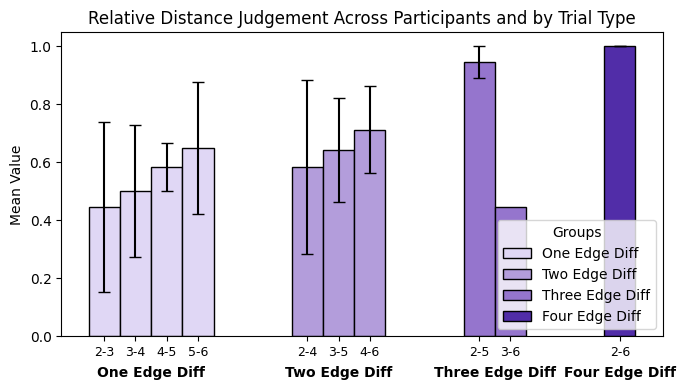

In [83]:
bad_partid = ['5cba50bf114fa5001aac5570','6657584ca6e3645f4a99e753','67e2b86a96de1816df85cefe','5fadeb340e10471fdeb5fbf5']
direct_df = df_flights[df_flights['trial_type']=='directmemory_phase']
direct_df = direct_df.loc[:, ~direct_df.isna().all()]
direct_df = direct_df.drop(columns=['time_elapsed','cumulative_accuracy','weighted_accuracy','missedtrial']).reset_index(drop='index')
direct_df = direct_df.map(lambda x: x.replace('../static/images/US_Cities_List/', '') if isinstance(x, str) else x)
direct_df = direct_df.map(lambda x: x.replace('../static/images/Fictional_Cities_List/', '') if isinstance(x, str) else x)
direct_df = direct_df.map(lambda x: x.replace('../static/images/GW/', '') if isinstance(x, str) else x)

shortest_df = df_flights[df_flights['trial_type']=='shortestpath_phase']
shortest_df = shortest_df.loc[:, ~shortest_df.isna().all()]
shortest_df = shortest_df.drop(columns=['time_elapsed','cumulative_accuracy']).reset_index(drop='index')
shortest_df = shortest_df.map(lambda x: x.replace('../static/images/US_Cities_List/', '') if isinstance(x, str) else x)
shortest_df = shortest_df.map(lambda x: x.replace('../static/images/Fictional_Cities_List/', '') if isinstance(x, str) else x)
shortest_df = shortest_df.map(lambda x: x.replace('../static/images/GW/', '') if isinstance(x, str) else x)

# Step 1: Combine stimulus and stimulus_correct into one long-form df with accuracy
long_direct_df = pd.concat([
    direct_df[['partid', 'stimulus', 'accuracy']].rename(columns={'stimulus': 'city'}),
    direct_df[['partid', 'stimulus_correct', 'accuracy']].rename(columns={'stimulus_correct': 'city'})
])

# Step 2: Group by participant and city, then check if all accuracies were 1.0
city_accuracy = long_direct_df.groupby(['partid', 'city'])['accuracy'].agg(lambda x: (x == 1.0).all()).reset_index()
city_accuracy = city_accuracy[city_accuracy['accuracy']]  # Keep only 100% accurate cities
city_accuracy = city_accuracy.drop(columns='accuracy')     # Just keep partid and city

# Step 3: Filter shortest_df by keeping only rows where both cities were 100% accurate
filtered_shortest_df = shortest_df[
    shortest_df.apply(
        lambda row: (
            (row['partid'], row['stimulus']) in city_accuracy.set_index(['partid', 'city']).index and
            (row['partid'], row['stimulus_correct']) in city_accuracy.set_index(['partid', 'city']).index
        ),
        axis=1
    )
]
grouped_shortest = filtered_shortest_df.groupby(['partid','specific_pairs'])['accuracy'].agg(['mean','count']).reset_index()

twothree = grouped_shortest[grouped_shortest['specific_pairs']=='Two Edge Three Edge']
threefour = grouped_shortest[grouped_shortest['specific_pairs']=='Three Edge Four Edge']
fourfive = grouped_shortest[grouped_shortest['specific_pairs']=='Four Edge Five Edge']
fivesix = grouped_shortest[grouped_shortest['specific_pairs']=='Five Edge Six Edge']

twofour = grouped_shortest[grouped_shortest['specific_pairs']=='Two Edge Four Edge']
threefive = grouped_shortest[grouped_shortest['specific_pairs']=='Three Edge Five Edge']
foursix = grouped_shortest[grouped_shortest['specific_pairs']=='Four Edge Six Edge']

twofive = grouped_shortest[grouped_shortest['specific_pairs']=='Two Edge Five Edge']
threesix = grouped_shortest[grouped_shortest['specific_pairs']=='Three Edge Six Edge']

twosix = grouped_shortest[grouped_shortest['specific_pairs']=='Two Edge Six Edge']

# --- Sample Data ---
group_labels = ['One Edge Diff', 'Two Edge Diff', 'Three Edge Diff', 'Four Edge Diff']

# Generate dummy data
heights = [
    [twothree['mean'].mean(), threefour['mean'].mean(), fourfive['mean'].mean(), fivesix['mean'].mean()],  # One diff
    [twofour['mean'].mean(), threefive['mean'].mean(), foursix['mean'].mean()],       # Two diff
    [twofive['mean'].mean(), threesix['mean'].mean()],            # Three diff
    [twosix['mean'].mean()]                  # Four diff
]

errors = [
    [twothree['mean'].sem(), threefour['mean'].sem(), fourfive['mean'].sem(), fivesix['mean'].sem()],  # One diff
    [twofour['mean'].sem(), threefive['mean'].sem(), foursix['mean'].sem()],       # Two diff
    [twofive['mean'].sem(), threesix['mean'].sem()],            # Three diff
    [twosix['mean'].sem()]                  # Four diff
]

bar_labels = [
    ['2-3', '3-4', '4-5', '5-6'],     # One diff
    ['2-4', '3-5', '4-6'],          # Two diff
    ['2-5', '3-6'],               # Three diff
    ['2-6']                    # Four diff
]

bar_width = 0.2
group_gap = 0.5

fig, ax = plt.subplots(figsize=(7, 4))

x_offset = 0
all_positions = []
all_labels = []
group_centers = []
# Optional: participant-level means
participant_means = shortest_df.groupby(['partid', 'specific_pairs'])['accuracy'].mean().reset_index()

# Then Tukey test on those
# tukey = pairwise_tukeyhsd(endog=participant_means['accuracy'],
#                         groups=participant_means['specific_pairs'],
#                         alpha=0.05)
# print(tukey.summary())
# Define blue color shades (lightest to darkest)
group_colors = ['#e0d7f5', '#b39ddb', '#9575cd', '#512da8']
# group_colors = ['#cce5ff', '#66b3ff', '#1f78b4', '#08306b']  # Adjust or expand as needed

for i, (group, group_err, labels) in enumerate(zip(heights, errors, bar_labels)):
    num_bars = len(group)
    positions = np.arange(num_bars) * bar_width + x_offset
    ax.bar(positions, group, yerr=group_err, capsize=4, width=bar_width,
        edgecolor='black', label=group_labels[i], color=group_colors[i])
    
    # Store positions and labels for x-ticks
    all_positions.extend(positions)
    all_labels.extend(labels)
    
    # Calculate center of group for big group label
    group_centers.append(positions.mean())
    
    # Update x offset for next group
    x_offset = positions[-1] + bar_width + group_gap

# Set small bar labels as x-tick labels
ax.set_xticks(all_positions)
ax.set_xticklabels(all_labels, fontsize=9)

# Add big group labels below
for center, label in zip(group_centers, group_labels):
    ax.text(center, -0.1, label, ha='center', va='top', fontsize=10,
            fontweight='bold', transform=ax.transData)
# --- Formatting ---
ax.legend(title='Groups')
ax.set_ylabel('Mean Value')
ax.set_title(f'Relative Distance Judgement Across Participants and by Trial Type')
plt.tight_layout()
plt.show()

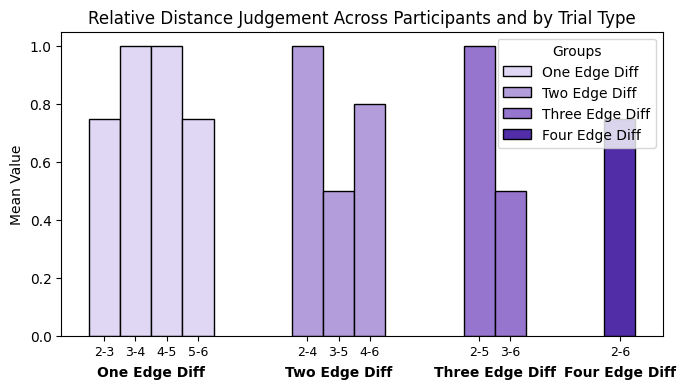

In [84]:
bad_partid = ['5cba50bf114fa5001aac5570','6657584ca6e3645f4a99e753','67e2b86a96de1816df85cefe','5fadeb340e10471fdeb5fbf5']
direct_df = df_rep[df_rep['trial_type']=='directmemory_phase']
direct_df = direct_df.loc[:, ~direct_df.isna().all()]
direct_df = direct_df.drop(columns=['time_elapsed','cumulative_accuracy','weighted_accuracy']).reset_index(drop='index')
direct_df = direct_df.map(lambda x: x.replace('../static/images/US_Cities_List/', '') if isinstance(x, str) else x)
direct_df = direct_df.map(lambda x: x.replace('../static/images/Fictional_Cities_List/', '') if isinstance(x, str) else x)
direct_df = direct_df.map(lambda x: x.replace('../static/images/GW/', '') if isinstance(x, str) else x)

shortest_df = df_rep[df_rep['trial_type']=='shortestpath_phase']
shortest_df = shortest_df.loc[:, ~shortest_df.isna().all()]
shortest_df = shortest_df.drop(columns=['time_elapsed','cumulative_accuracy']).reset_index(drop='index')
shortest_df = shortest_df.map(lambda x: x.replace('../static/images/US_Cities_List/', '') if isinstance(x, str) else x)
shortest_df = shortest_df.map(lambda x: x.replace('../static/images/Fictional_Cities_List/', '') if isinstance(x, str) else x)
shortest_df = shortest_df.map(lambda x: x.replace('../static/images/GW/', '') if isinstance(x, str) else x)

# Step 1: Combine stimulus and stimulus_correct into one long-form df with accuracy
long_direct_df = pd.concat([
    direct_df[['partid', 'stimulus', 'accuracy']].rename(columns={'stimulus': 'city'}),
    direct_df[['partid', 'stimulus_correct', 'accuracy']].rename(columns={'stimulus_correct': 'city'})
])

# Step 2: Group by participant and city, then check if all accuracies were 1.0
city_accuracy = long_direct_df.groupby(['partid', 'city'])['accuracy'].agg(lambda x: (x == 1.0).all()).reset_index()
city_accuracy = city_accuracy[city_accuracy['accuracy']]  # Keep only 100% accurate cities
city_accuracy = city_accuracy.drop(columns='accuracy')     # Just keep partid and city

# Step 3: Filter shortest_df by keeping only rows where both cities were 100% accurate
filtered_shortest_df = shortest_df[
    shortest_df.apply(
        lambda row: (
            (row['partid'], row['stimulus']) in city_accuracy.set_index(['partid', 'city']).index and
            (row['partid'], row['stimulus_correct']) in city_accuracy.set_index(['partid', 'city']).index
        ),
        axis=1
    )
]
grouped_shortest = filtered_shortest_df.groupby(['partid','specific_pairs'])['accuracy'].agg(['mean','count']).reset_index()

twothree = grouped_shortest[grouped_shortest['specific_pairs']=='Two Edge Three Edge']
threefour = grouped_shortest[grouped_shortest['specific_pairs']=='Three Edge Four Edge']
fourfive = grouped_shortest[grouped_shortest['specific_pairs']=='Four Edge Five Edge']
fivesix = grouped_shortest[grouped_shortest['specific_pairs']=='Five Edge Six Edge']

twofour = grouped_shortest[grouped_shortest['specific_pairs']=='Two Edge Four Edge']
threefive = grouped_shortest[grouped_shortest['specific_pairs']=='Three Edge Five Edge']
foursix = grouped_shortest[grouped_shortest['specific_pairs']=='Four Edge Six Edge']

twofive = grouped_shortest[grouped_shortest['specific_pairs']=='Two Edge Five Edge']
threesix = grouped_shortest[grouped_shortest['specific_pairs']=='Three Edge Six Edge']

twosix = grouped_shortest[grouped_shortest['specific_pairs']=='Two Edge Six Edge']

# --- Sample Data ---
group_labels = ['One Edge Diff', 'Two Edge Diff', 'Three Edge Diff', 'Four Edge Diff']

# Generate dummy data
heights = [
    [twothree['mean'].mean(), threefour['mean'].mean(), fourfive['mean'].mean(), fivesix['mean'].mean()],  # One diff
    [twofour['mean'].mean(), threefive['mean'].mean(), foursix['mean'].mean()],       # Two diff
    [twofive['mean'].mean(), threesix['mean'].mean()],            # Three diff
    [twosix['mean'].mean()]                  # Four diff
]

errors = [
    [twothree['mean'].sem(), threefour['mean'].sem(), fourfive['mean'].sem(), fivesix['mean'].sem()],  # One diff
    [twofour['mean'].sem(), threefive['mean'].sem(), foursix['mean'].sem()],       # Two diff
    [twofive['mean'].sem(), threesix['mean'].sem()],            # Three diff
    [twosix['mean'].sem()]                  # Four diff
]

bar_labels = [
    ['2-3', '3-4', '4-5', '5-6'],     # One diff
    ['2-4', '3-5', '4-6'],          # Two diff
    ['2-5', '3-6'],               # Three diff
    ['2-6']                    # Four diff
]

bar_width = 0.2
group_gap = 0.5

fig, ax = plt.subplots(figsize=(7, 4))

x_offset = 0
all_positions = []
all_labels = []
group_centers = []
# Optional: participant-level means
participant_means = shortest_df.groupby(['partid', 'specific_pairs'])['accuracy'].mean().reset_index()

# Then Tukey test on those
# tukey = pairwise_tukeyhsd(endog=participant_means['accuracy'],
#                         groups=participant_means['specific_pairs'],
#                         alpha=0.05)
# print(tukey.summary())
# Define blue color shades (lightest to darkest)
group_colors = ['#e0d7f5', '#b39ddb', '#9575cd', '#512da8']
# group_colors = ['#cce5ff', '#66b3ff', '#1f78b4', '#08306b']  # Adjust or expand as needed

for i, (group, group_err, labels) in enumerate(zip(heights, errors, bar_labels)):
    num_bars = len(group)
    positions = np.arange(num_bars) * bar_width + x_offset
    ax.bar(positions, group, yerr=group_err, capsize=4, width=bar_width,
        edgecolor='black', label=group_labels[i], color=group_colors[i])
    
    # Store positions and labels for x-ticks
    all_positions.extend(positions)
    all_labels.extend(labels)
    
    # Calculate center of group for big group label
    group_centers.append(positions.mean())
    
    # Update x offset for next group
    x_offset = positions[-1] + bar_width + group_gap

# Set small bar labels as x-tick labels
ax.set_xticks(all_positions)
ax.set_xticklabels(all_labels, fontsize=9)

# Add big group labels below
for center, label in zip(group_centers, group_labels):
    ax.text(center, -0.1, label, ha='center', va='top', fontsize=10,
            fontweight='bold', transform=ax.transData)
# --- Formatting ---
ax.legend(title='Groups')
ax.set_ylabel('Mean Value')
ax.set_title(f'Relative Distance Judgement Across Participants and by Trial Type')
plt.tight_layout()
plt.show()

In [85]:
df_flights['condition'].unique()

array([nan, 'One Edge Diff', 'Two Edge Diff', '1', 'Three Edge Diff',
       'Four Edge Diff'], dtype=object)

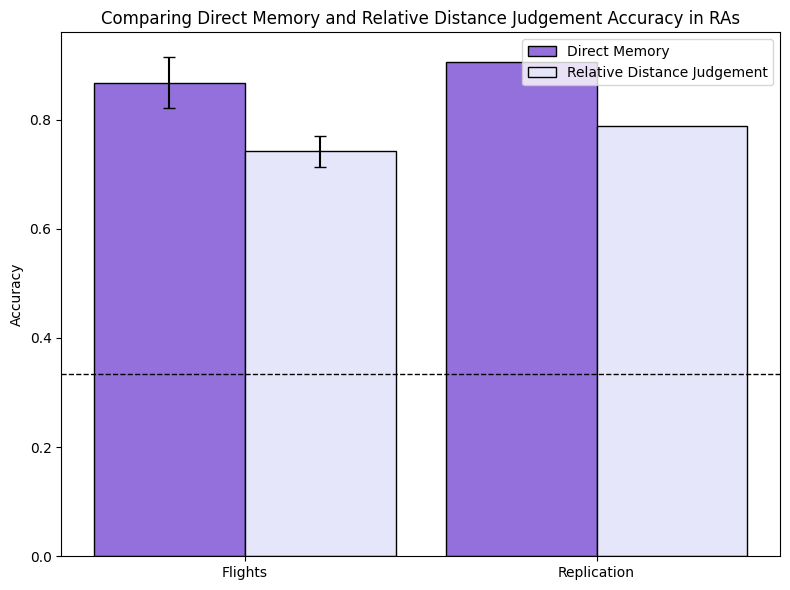

In [86]:
from matplotlib.patches import Patch
def get_chosen_city(row):
    if  row['key_press'] == 49:
        return row['stimulus_down_left']
    elif  row['key_press'] == 50:
        return row['stimulus_down_mid']
    elif  row['key_press'] == 51:
        return row['stimulus_down_right']
    else: return pd.NA

def get_wrong_distance(row):
    if pd.isna(row['stimulus_selected']):
        return pd.NA
    elif row['stimulus_selected'] == row['stimulus_short']:
        return 'close'
    elif row['stimulus_selected'] == row['stimulus_far']:
        return 'far'
    elif row['stimulus_selected'] == row['stimulus_correct']:
        return 'correct'
    else: return pd.NA

def get_weighted_correct(row):
    if pd.isna(row['wrong_distance']):
        return pd.NA
    elif row['wrong_distance'] == 'close':
        return 0.5
    elif row['wrong_distance'] == 'far':
        return 0
    elif row['wrong_distance'] == 'correct':
        return 1
    else: return pd.NA

# df_flights = df_flights[~df_flights['stimulus'].isna()]
direct_df_flights = df_flights[df_flights['trial_type']=='directmemory_phase']
direct_df_flights = direct_df_flights.loc[:, ~direct_df_flights.isna().all()]
direct_df_flights = direct_df_flights.drop(columns=['time_elapsed','cumulative_accuracy','weighted_accuracy','missedtrial']).reset_index(drop='index')
direct_df_flights = direct_df_flights.map(lambda x: x.replace('../static/images/US_Cities_List/', '') if isinstance(x, str) else x)
direct_df_flights = direct_df_flights.map(lambda x: x.replace('../static/images/Fictional_Cities_List/', '') if isinstance(x, str) else x)
direct_df_flights = direct_df_flights.map(lambda x: x.replace('../static/images/GW/', '') if isinstance(x, str) else x)

# for id in bad_partid:
#     direct_df = direct_df[direct_df['partid'] != id]

direct_df_flights['stimulus_selected'] = direct_df_flights.apply(get_chosen_city,axis=1)
direct_df_flights['wrong_distance'] = direct_df_flights.apply(get_wrong_distance,axis=1)
direct_df_flights['weighted_correct'] = direct_df_flights.apply(get_weighted_correct,axis=1)
direct_df_flights = direct_df_flights[(direct_df_flights['rt']>400)&(direct_df_flights['rt']<5000)]

direct_young1 = direct_df_flights.groupby('partid')['accuracy'].mean()
direct_young1

df_short = df_flights[(df_flights['trial_type']=='shortestpath_phase') & df_flights['stimulus'].notna() & (df_flights['rt'] > 400) & (df_flights['rt'] < 5000)]
df_short1 = df_short.groupby('partid')['accuracy'].mean()
###
# df_rep = df_rep[~df_rep['stimulus'].isna()]
direct_df_flights = df_rep[df_rep['trial_type']=='directmemory_phase']
direct_df_flights = direct_df_flights.loc[:, ~direct_df_flights.isna().all()]
direct_df_flights = direct_df_flights.drop(columns=['time_elapsed','cumulative_accuracy','weighted_accuracy']).reset_index(drop='index')
direct_df_flights = direct_df_flights.map(lambda x: x.replace('../static/images/US_Cities_List/', '') if isinstance(x, str) else x)
direct_df_flights = direct_df_flights.map(lambda x: x.replace('../static/images/Fictional_Cities_List/', '') if isinstance(x, str) else x)
direct_df_flights = direct_df_flights.map(lambda x: x.replace('../static/images/GW/', '') if isinstance(x, str) else x)

# for id in bad_partid:
#     direct_df = direct_df[direct_df['partid'] != id]

direct_df_flights['stimulus_selected'] = direct_df_flights.apply(get_chosen_city,axis=1)
direct_df_flights['wrong_distance'] = direct_df_flights.apply(get_wrong_distance,axis=1)
direct_df_flights['weighted_correct'] = direct_df_flights.apply(get_weighted_correct,axis=1)
# direct_df_flights = direct_df_flights[(direct_df_flights['rt']>400)&(direct_df_flights['rt']<500000)]

direct_young2 = direct_df_flights.groupby('partid')['accuracy'].mean()
direct_young2

df_short = df_rep[(df_rep['trial_type']=='shortestpath_phase') & df_rep['stimulus'].notna() & (df_rep['rt'] > 400) & (df_rep['rt'] < 5000)]
df_short2 = df_short.groupby('partid')['accuracy'].mean()

plt.figure(figsize=(8,6))
plt.bar(x=0.3,height= direct_young1.mean(),yerr=direct_young1.sem(),capsize=4,color='mediumpurple',width=0.3,edgecolor='black',label='Direct Memory')
plt.bar(x=.6,height= df_short1.mean(),yerr=df_short1.sem(),capsize=4,color='lavender',width=0.3,edgecolor='black',label='Relative Distance Judgement')
plt.bar(x=1,height= direct_young2.mean(),yerr=direct_young2.sem(),capsize=4,color='mediumpurple',width=0.3,edgecolor='black')
plt.bar(x=1.3,height= df_short2.mean(),yerr=df_short2.sem(),capsize=4,color='lavender',width=0.3,edgecolor='black')


plt.xticks([0.45,1.15],['Flights','Replication'])
plt.ylabel( "Accuracy")
plt.title(f"Comparing Direct Memory and Relative Distance Judgement Accuracy in RAs")
plt.legend()
plt.axhline(y=0.3333, color='black', linestyle='--', linewidth=1)
plt.grid(False)
plt.tight_layout()
plt.show()


In [87]:
direct_young2.mean()

np.float64(0.90625)

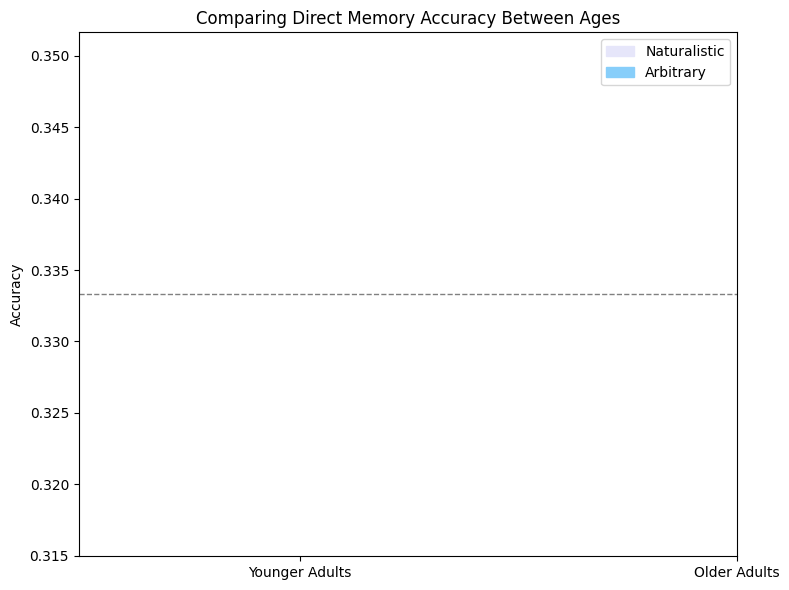

Younger Adults t-test (Flights vs Replication):
t = nan, p = nan

Older Adults t-test (Flights vs Replication):
t = nan, p = nan

T-tests vs Chance (0.333):
Younger - Flights: Not enough data for t-test
Younger - Replication: Not enough data for t-test
Older - Flights: Not enough data for t-test
Older - Replication: Not enough data for t-test


/var/folders/80/x27szhys5v384yshvf0yrws40000gn/T/ipykernel_30098/3290192832.py:70: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_young = ttest_ind(direct_young1, direct_young2, equal_var=False)
/var/folders/80/x27szhys5v384yshvf0yrws40000gn/T/ipykernel_30098/3290192832.py:75: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_old = ttest_ind(direct_old1, direct_old2, equal_var=False)


In [88]:
from matplotlib.patches import Patch
df_rep["age"]='Young'
df_flights["age"]='Young'
def get_stacked_direct_plots(df1,df2,exp_type1,exp_type2):
    df1 = df1[~df1['stimulus'].isna()]
    df2 = df2[~df2['stimulus'].isna()]
    direct_df1 = df1[df1['trial_type']=='directmemory_phase']
    direct_df1 = direct_df1.loc[:, ~direct_df1.isna().all()]
    direct_df1 = direct_df1.drop(columns=['time_elapsed','cumulative_accuracy','weighted_accuracy','missedtrial']).reset_index(drop='index')
    direct_df1 = direct_df1.map(lambda x: x.replace('../static/images/US_Cities_List/', '') if isinstance(x, str) else x)
    direct_df1 = direct_df1.map(lambda x: x.replace('../static/images/Fictional_Cities_List/', '') if isinstance(x, str) else x)
    direct_df1 = direct_df1.map(lambda x: x.replace('../static/images/GW/', '') if isinstance(x, str) else x)

    # for id in bad_partid:
    #     direct_df = direct_df[direct_df['partid'] != id]

    direct_df1['stimulus_selected'] = direct_df1.apply(get_chosen_city,axis=1)
    direct_df1['wrong_distance'] = direct_df1.apply(get_wrong_distance,axis=1)
    direct_df1['weighted_correct'] = direct_df1.apply(get_weighted_correct,axis=1)
    direct_df1 = direct_df1[(direct_df1['rt']>400)&(direct_df1['rt']<5000)]

    direct_old1 = direct_df1[direct_df1['age'] == 'old'].groupby('partid')['accuracy'].mean()
    direct_young1 = direct_df1[direct_df1['age'] == 'young'].groupby('partid')['accuracy'].mean()
    if exp_type1 == 'Flights':
        color1 = ['lavender','lavender','purple']
    elif exp_type1 == 'Replication':
        color1 = ['lightskyblue','lightblue','blue']

    direct_df2 = df2[df2['trial_type']=='directmemory_phase']
    direct_df2 = direct_df2.loc[:, ~direct_df2.isna().all()]
    direct_df2 = direct_df2.drop(columns=['time_elapsed','cumulative_accuracy','weighted_accuracy']).reset_index(drop='index')
    direct_df2 = direct_df2.map(lambda x: x.replace('../static/images/US_Cities_List/', '') if isinstance(x, str) else x)
    direct_df2 = direct_df2.map(lambda x: x.replace('../static/images/Fictional_Cities_List/', '') if isinstance(x, str) else x)
    direct_df2 = direct_df2.map(lambda x: x.replace('../static/images/GW/', '') if isinstance(x, str) else x)
    direct_df2 = direct_df2[(direct_df2['rt']>400)&(direct_df2['rt']<5000)]

    # for id in bad_partid:
    #     direct_df = direct_df[direct_df['partid'] != id]

    direct_df2['stimulus_selected'] = direct_df2.apply(get_chosen_city,axis=1)
    direct_df2['wrong_distance'] = direct_df2.apply(get_wrong_distance,axis=1)
    direct_df2['weighted_correct'] = direct_df2.apply(get_weighted_correct,axis=1)


    direct_old2 = direct_df2[direct_df2['age'] == 'old'].groupby('partid')['accuracy'].mean()
    direct_young2 = direct_df2[direct_df2['age'] == 'young'].groupby('partid')['accuracy'].mean()
    if exp_type2 == 'Flights':
        color2 = ['lavender','lavender','purple']
    elif exp_type2 == 'Replication':
        color2 = ['lightskyblue','lightblue','blue']
    # Bar chart of prob

    plt.figure(figsize=(8,6))
    plt.bar(x=0.2,height= direct_young1.mean(),yerr=direct_young1.sem(),capsize=4,color=color1[0],width=0.3,edgecolor='black',label='Naturalistic Framed')
    plt.bar(x=1,height=direct_old1.mean(),yerr=direct_old1.sem(),capsize=4,color=color1[0],width=0.3,edgecolor='black',label='Naturalistic Framed')
    plt.bar(x=0.5,height= direct_young2.mean(),yerr=direct_young2.sem(),capsize=4,color=color2[0],width=0.3,edgecolor='black',label='Abstract')
    plt.bar(x=1.3,height=direct_old2.mean(),yerr=direct_old2.sem(),capsize=4,color=color2[0],width=0.3,edgecolor='black',label='Abstract')
    plt.axhline(y=0.3333, color='gray', linestyle='--', linewidth=1)
    plt.xticks([0.35,1.15],['Younger Adults','Older Adults'])
    plt.ylabel( "Accuracy")
    plt.title(f"Comparing Direct Memory Accuracy Between Ages")
    handles = [Patch(color=color1[0], label='Naturalistic'), Patch(color=color2[0], label='Arbitrary')]
    plt.legend(handles=handles)
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    from scipy.stats import ttest_ind

    # Younger adults: Flights vs Replication
    t_young = ttest_ind(direct_young1, direct_young2, equal_var=False)
    print("Younger Adults t-test (Flights vs Replication):")
    print(f"t = {t_young.statistic:.3f}, p = {t_young.pvalue:.3f}")

    # Older adults: Flights vs Replication
    t_old = ttest_ind(direct_old1, direct_old2, equal_var=False)
    print("\nOlder Adults t-test (Flights vs Replication):")
    print(f"t = {t_old.statistic:.3f}, p = {t_old.pvalue:.3f}")

    from scipy.stats import ttest_1samp

    # Chance level
    chance_level = 0.3333333

    print("\nT-tests vs Chance (0.333):")
    # Younger Adults
    if len(direct_young1) > 1:
        t_young1 = ttest_1samp(direct_young1, popmean=chance_level)
        print(f"Younger - Flights: t = {t_young1.statistic:.3f}, p = {t_young1.pvalue:.3e}, mean = {direct_young1.mean():.3f}")
    else:
        print("Younger - Flights: Not enough data for t-test")

    if len(direct_young2) > 1:
        t_young2 = ttest_1samp(direct_young2, popmean=chance_level)
        print(f"Younger - Replication: t = {t_young2.statistic:.3f}, p = {t_young2.pvalue:.3e}, mean = {direct_young2.mean():.3f}")
    else:
        print("Younger - Replication: Not enough data for t-test")

    # Older Adults
    if len(direct_old1) > 1:
        t_old1 = ttest_1samp(direct_old1, popmean=chance_level)
        print(f"Older - Flights: t = {t_old1.statistic:.3f}, p = {t_old1.pvalue:.3e}, mean = {direct_old1.mean():.3f}")
    else:
        print("Older - Flights: Not enough data for t-test")

    if len(direct_old2) > 1:
        t_old2 = ttest_1samp(direct_old2, popmean=chance_level)
        print(f"Older - Replication: t = {t_old2.statistic:.3f}, p = {t_old2.pvalue:.3e}, mean = {direct_old2.mean():.3f}")
    else:
        print("Older - Replication: Not enough data for t-test")
get_stacked_direct_plots(df_flights,df_rep,"Flights","Replication")

In [89]:
df_rep

,rt,responses,trial_type,time_elapsed,sequence,stimulus,graphorder,button_pressed,response,key_press,...,detour_trial,problems,smooth,distraction,strategies,easier,similar,comments,partid,age
0,158085.3,"{""worker_id"":""5116""}",id_enter,158087,blocked,id_enter,GW/globe.jpg; GW/soldier.jpg; GW/snail.jpg; GW...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""worker_id"":""5116""",Young
1,32307.5,NaN,fullscreen,190398,blocked,fullscreen,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""worker_id"":""5116""",Young
2,16984.8,NaN,intro_1,207385,blocked,instruct,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""worker_id"":""5116""",Young
3,17245.2,NaN,intro_2,224633,blocked,instruct,NaN,1.0,Next,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""worker_id"":""5116""",Young
4,42811.1,NaN,intro_3,267447,blocked,instruct,NaN,1.0,Next,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""worker_id"":""5116""",Young
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,12891.2,NaN,intro_1,2965257,blocked,instruct,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""worker_id"":""5116""",Young
967,28072.0,NaN,intro_2,2993333,blocked,instruct,NaN,1.0,Next,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""worker_id"":""5116""",Young
968,4281.7,NaN,intro_3,2997619,blocked,instruct,NaN,1.0,Next,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""worker_id"":""5116""",Young
969,NaN,NaN,Graph Reconstruction,3239278,blocked,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""worker_id"":""5116""",Young
